# Imports

In [2]:
! pip install NRCLex==3.0.0


[notice] A new release of pip is available: 23.0 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
! py -m pip install matplotlib

  Using cached matplotlib-3.9.0-cp39-cp39-win_amd64.whl (7.9 MB)


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\jessi\\AppData\\Local\\Programs\\Python\\Python39\\Lib\\site-packages\\matplotlib\\ft2font.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip is available: 23.0 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import tensorflow as tf
import os
import random
import requests
from wordcloud import WordCloud
import regex as re
import string
from collections import Counter
from nrclex import NRCLex
import nltk.corpus
from nltk.corpus import stopwords, wordnet, words
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'c:\\Users\\jessi\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\matplotlib.libs'

# Data

In [64]:
df = pd.read_csv('C:/Users/jessi/tswift_lyrics/genius_lyrics_collection/tswift_lyrics.csv')
df.head()

,Album,Song Name,Lyrics
0,Taylor Swift,A Perfectly Good Heart,why would you wanna break a perfectly good hea...
1,Taylor Swift,A Place In This World,i dont know what i want so dont ask me cause i...
2,Taylor Swift,Cold as You,you have a way of coming easily to me and when...
3,Taylor Swift,I'm Only Me When I'm With You,friday night beneath the stars in a field behi...
4,Taylor Swift,Invisible,she cant see the way your eyes light up when y...


## Text Cleaning and Tokenization

In [65]:
english_words = set(words.words())

# preprocess data
tokens = word_tokenize(' '.join(df['Lyrics']))
stop = set(stopwords.words('english'))

# filter out stopwords, punctuation, and words starting with apostrophe
filtered_tokens = [word.lower() for word in tokens
                   if word.strip()
                   and word.lower() not in stop
                   and wordnet.synsets(word)
                   and len(word) > 2
                   and word.lower() in english_words]

# initialize wordnet lemmatizer
lemmatizer = WordNetLemmatizer()

# create new column for lemmatized lyrics
df['lemmatized_lyrics'] = df['tokenized_lyrics'].apply(lambda lst:[lemmatizer.lemmatize(word) for word in lst])

In [66]:
# join words in 'lemmatized_lyric' column to single list
lyric_words = df['lemmatized_lyrics'].explode().to_list()

# create pandas series from list
lyric_series = pd.Series(lyric_words)

print(len(lyric_words))
print(lyric_words[:100])

# # join tokens (words in 'Lyrics' column) to single string
# lyric_text = ' '.join(filtered_tokens)

# print(len(filtered_tokens))
# print(filtered_tokens[:100])

29989
['wan', 'break', 'perfectly', 'good', 'heart', 'wan', 'take', 'love', 'tear', 'apart', 'wan', 'make', 'first', 'scar', 'wan', 'break', 'perfectly', 'good', 'heart', 'maybe', 'seen', 'read', 'writing', 'wall', 'distance', 'one', 'fall', 'matter', 'say', 'still', 'cant', 'believe', 'walk', 'away', 'make', 'sense', 'wan', 'break', 'perfectly', 'good', 'heart', 'wan', 'take', 'love', 'tear', 'apart', 'wan', 'make', 'first', 'scar', 'wan', 'break', 'perfectly', 'good', 'heart', 'unbroken', 'unbroken', 'get', 'back', 'way', 'wan', 'break', 'perfectly', 'good', 'heart', 'wan', 'take', 'love', 'tear', 'apart', 'wan', 'make', 'first', 'scar', 'wan', 'wan', 'break', 'wan', 'break', 'perfectly', 'good', 'heart', 'wan', 'take', 'love', 'tear', 'apart', 'wan', 'make', 'first', 'scar', 'wan', 'break', 'perfectly', 'good', 'heart', 'know', 'want', 'ask', 'cause']


# Sentiment Analysis

In [67]:
# initialize SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# calculate sentiment scores for entire text
sentiment_score = analyzer.polarity_scores(lyric_text)

# extract individual scores
neg = sentiment_score['neg']
neu = sentiment_score['neu']
pos = sentiment_score['pos']

sentiment_score

{'neg': 0.17, 'neu': 0.549, 'pos': 0.281, 'compound': 1.0}

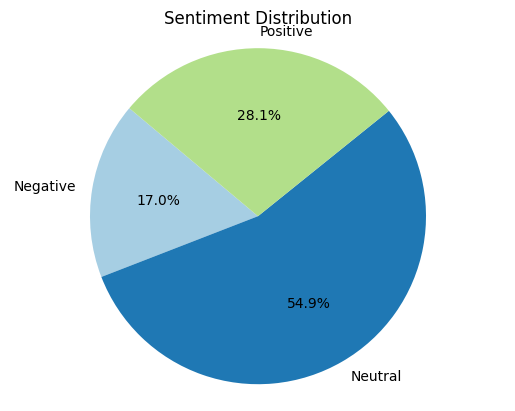

In [68]:
# create labels for pie chart
labels = ['Negative', 'Neutral', 'Positive']

# create sizes for each sentiment category
sizes = [neg, neu, pos]

# plot pie chart
plt.figure()
plt.pie(sizes,
        labels = labels,
        colors = plt.cm.Paired.colors,
        autopct = '%1.1f%%',
        startangle = 140)
plt.title('Sentiment Distribution')
plt.axis('equal')
plt.show()

In [69]:
# initialize list of word sentiments
word_sentiments = []

# initialize variables to accumulate sentiment scores
pos_score_sum = 0
neg_score_sum = 0
neu_score_sum = 0
pos_count = 0
neg_count = 0
neu_count = 0
total_words = 0

# count occurrences of each sentiment and accumulate sentiment scores
for word in filtered_tokens:
    total_words += 1
    sentiment_score = analyzer.polarity_scores(word)['compound']
    if sentiment_score >= 0.05:
        word_sentiments.append(('Positive', word))
        pos_count += 1
        pos_score_sum += sentiment_score
    elif sentiment_score <= (-0.05):
        word_sentiments.append(('Negative', word))
        neg_count += 1
        neg_score_sum += sentiment_score
    else:
        word_sentiments.append(('Neutral', word))
        neu_count += 1
        neu_score_sum += sentiment_score
    
# calculate avg sentiment score for each emotion
avg_pos_score = pos_score_sum / pos_count if pos_count != 0 else 0
avg_neg_score = neg_score_sum / neg_count if neg_count != 0 else 0
avg_neu_score = neu_score_sum / neu_count if neu_count != 0 else 0
avg_total_score = (pos_score_sum + neg_score_sum + neu_score_sum) / total_words

# print results
print('pos:', pos_count)
print('neg:', neg_count)
print('neu:', neu_count)
print('Total:', total_words)

# Print results with two decimal places
print('Avg. Pos. Score: {:.2f}'.format(avg_pos_score))
print('Avg. Neg. Score: {:.2f}'.format(avg_neg_score))
print('Avg. Neu. Score: {:.2f}'.format(avg_neu_score))
print('Avg. Total Score: {:.2f}'.format(avg_total_score))

pos: 4257
neg: 2662
neu: 23070
Total: 29989
Avg. Pos. Score: 0.40
Avg. Neg. Score: -0.38
Avg. Neu. Score: 0.00
Avg. Total Score: 0.02


In [70]:
# create lists for each word type
all_words = [word for sentiment, word in word_sentiments]
pos_words = [word for sentiment, word in word_sentiments if sentiment == 'Positive']
neg_words = [word for sentiment, word in word_sentiments if sentiment == 'Negative']
neu_words = [word for sentiment, word in word_sentiments if sentiment == 'Neutral']

# count occurrences of each word type
word_counts = pd.Series(all_words).value_counts().head(200)
pos_word_counts = pd.Series(pos_words).value_counts().head(200)
neg_word_counts = pd.Series(neg_words).value_counts().head(200)
neu_word_counts = pd.Series(neu_words).value_counts().head(200)

# create dataframe to display the top of each word type
data = {
    'All Words': word_counts.index,
    'All Counts': word_counts.values,
    'Pos Words': pos_word_counts.index,
    'Pos Counts': pos_word_counts.values,
    'Neg Words': neg_word_counts.index,
    'Neg Counts': neg_word_counts.values,
    'Neu Words': neu_word_counts.index,
    'Neu Counts': neu_word_counts.values
    }
df_word_types = pd.DataFrame(data)
df_word_types.columns = ['All Words', 'All Counts', 'Pos Words', 'Pos Counts', 'Neg Words', 'Neg Counts', 'Neu Words', 'Neu Counts']

df_word_types.head()


,All Words,All Counts,Pos Words,Pos Counts,Neg Words,Neg Counts,Neu Words,Neu Counts
0,like,670,like,670,ill,205,know,583
1,know,583,love,408,bad,123,never,432
2,never,432,want,217,leave,79,time,380
3,love,408,yeah,194,miss,75,one,359
4,time,380,good,135,lost,75,cause,353


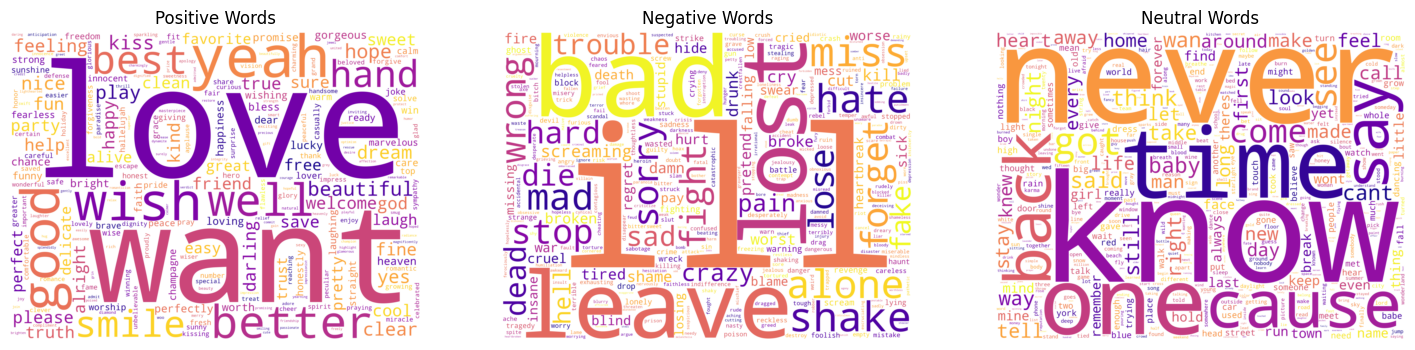

In [71]:
# generate wordclouds for each sentiment type
wordclouds = {}

for sentiment_type in ['Positive', 'Negative', 'Neutral']:
    words = [word[1] for word in word_sentiments if word[0] == sentiment_type]
    if words:
        wordcloud = WordCloud(relative_scaling=0.3,
                              min_font_size=1,
                              background_color='white',
                              width=1024,
                              height=768,
                              max_words=500,
                              colormap='plasma',
                              scale=3,
                              font_step=4,
                              collocations=False,
                              margin=5).generate(' '.join(words))
        wordclouds[sentiment_type] = wordcloud

# display wordclouds
plt.figure(figsize=(18, 6))
for i, sentiment_type in enumerate(['Positive', 'Negative', 'Neutral']):
    if sentiment_type in wordclouds:
        plt.subplot(1, 3, i+1)
        plt.imshow(wordclouds[sentiment_type], interpolation='bilinear')
        plt.title(sentiment_type + ' Words')
        plt.axis('off')
plt.show()

# note: does not show 'like'

In [72]:
text_object = NRCLex(' '.join(filtered_tokens))
text_object.affect_frequencies

{'fear': 0.09773036082733631,
 'anger': 0.06959891298877761,
 'anticip': 0.0,
 'trust': 0.08323687786221126,
 'surprise': 0.05414926274470334,
 'positive': 0.16622213275627798,
 'negative': 0.1537919581299381,
 'sadness': 0.10286346937748478,
 'disgust': 0.054904131649136934,
 'joy': 0.11529364400382466,
 'anticipation': 0.10220924966030899}

In [73]:
text_object.top_emotions

[('positive', 0.16622213275627798)]

In [74]:
# total no. of words
tot_words = len(text_object.words)
print('Total words in the text:', tot_words)

Total words in the text: 29989


In [75]:
# create dataframe
sentiment_scores = pd.DataFrame(list(text_object.raw_emotion_scores.items()))
sentiment_scores = sentiment_scores.rename(columns={0: 'Sentiment', 1: 'Count'})
sentiment_scores

,Sentiment,Count
0,fear,1942
1,negative,3056
2,sadness,2044
3,surprise,1076
4,anticipation,2031
5,joy,2291
6,positive,3303
7,trust,1654
8,anger,1383
9,disgust,1091


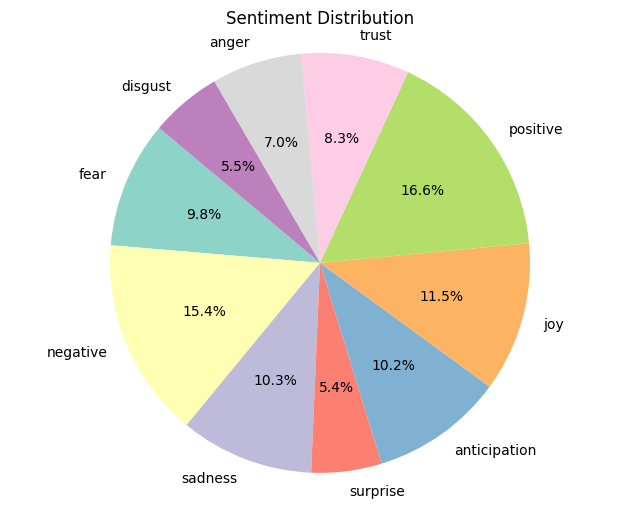

In [76]:
# pie chart
plt.figure(figsize=(8, 6))
plt.pie(sentiment_scores['Count'],
        labels=sentiment_scores['Sentiment'],
        colors=plt.cm.Set3.colors,
        autopct='%1.1f%%',
        startangle=140)
plt.title('Sentiment Distribution')
plt.axis('equal')
plt.show()

In [77]:
# define colormaps for each sentiment
sentiment_cmaps = {
    'fear': 'twilight',
    'anger': 'jet',
    'anticipation': 'twilight',
    'trust': 'ocean',
    'surprise': 'gnuplot2',
    'positive': 'hsv',
    'negative': 'spring',
    'sadness': 'PiYG',
    'disgust': 'gist_heat',
    'joy': 'gist_ncar'
    }

# all unique sentiments in the text
unique_sentiments = list(set(sentiment for emotions
                            in text_object.affect_dict.values()
                            for sentiment in emotions))

C:\Users\jessi\AppData\Local\Temp\ipykernel_24684\760333509.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(word_counts.index)


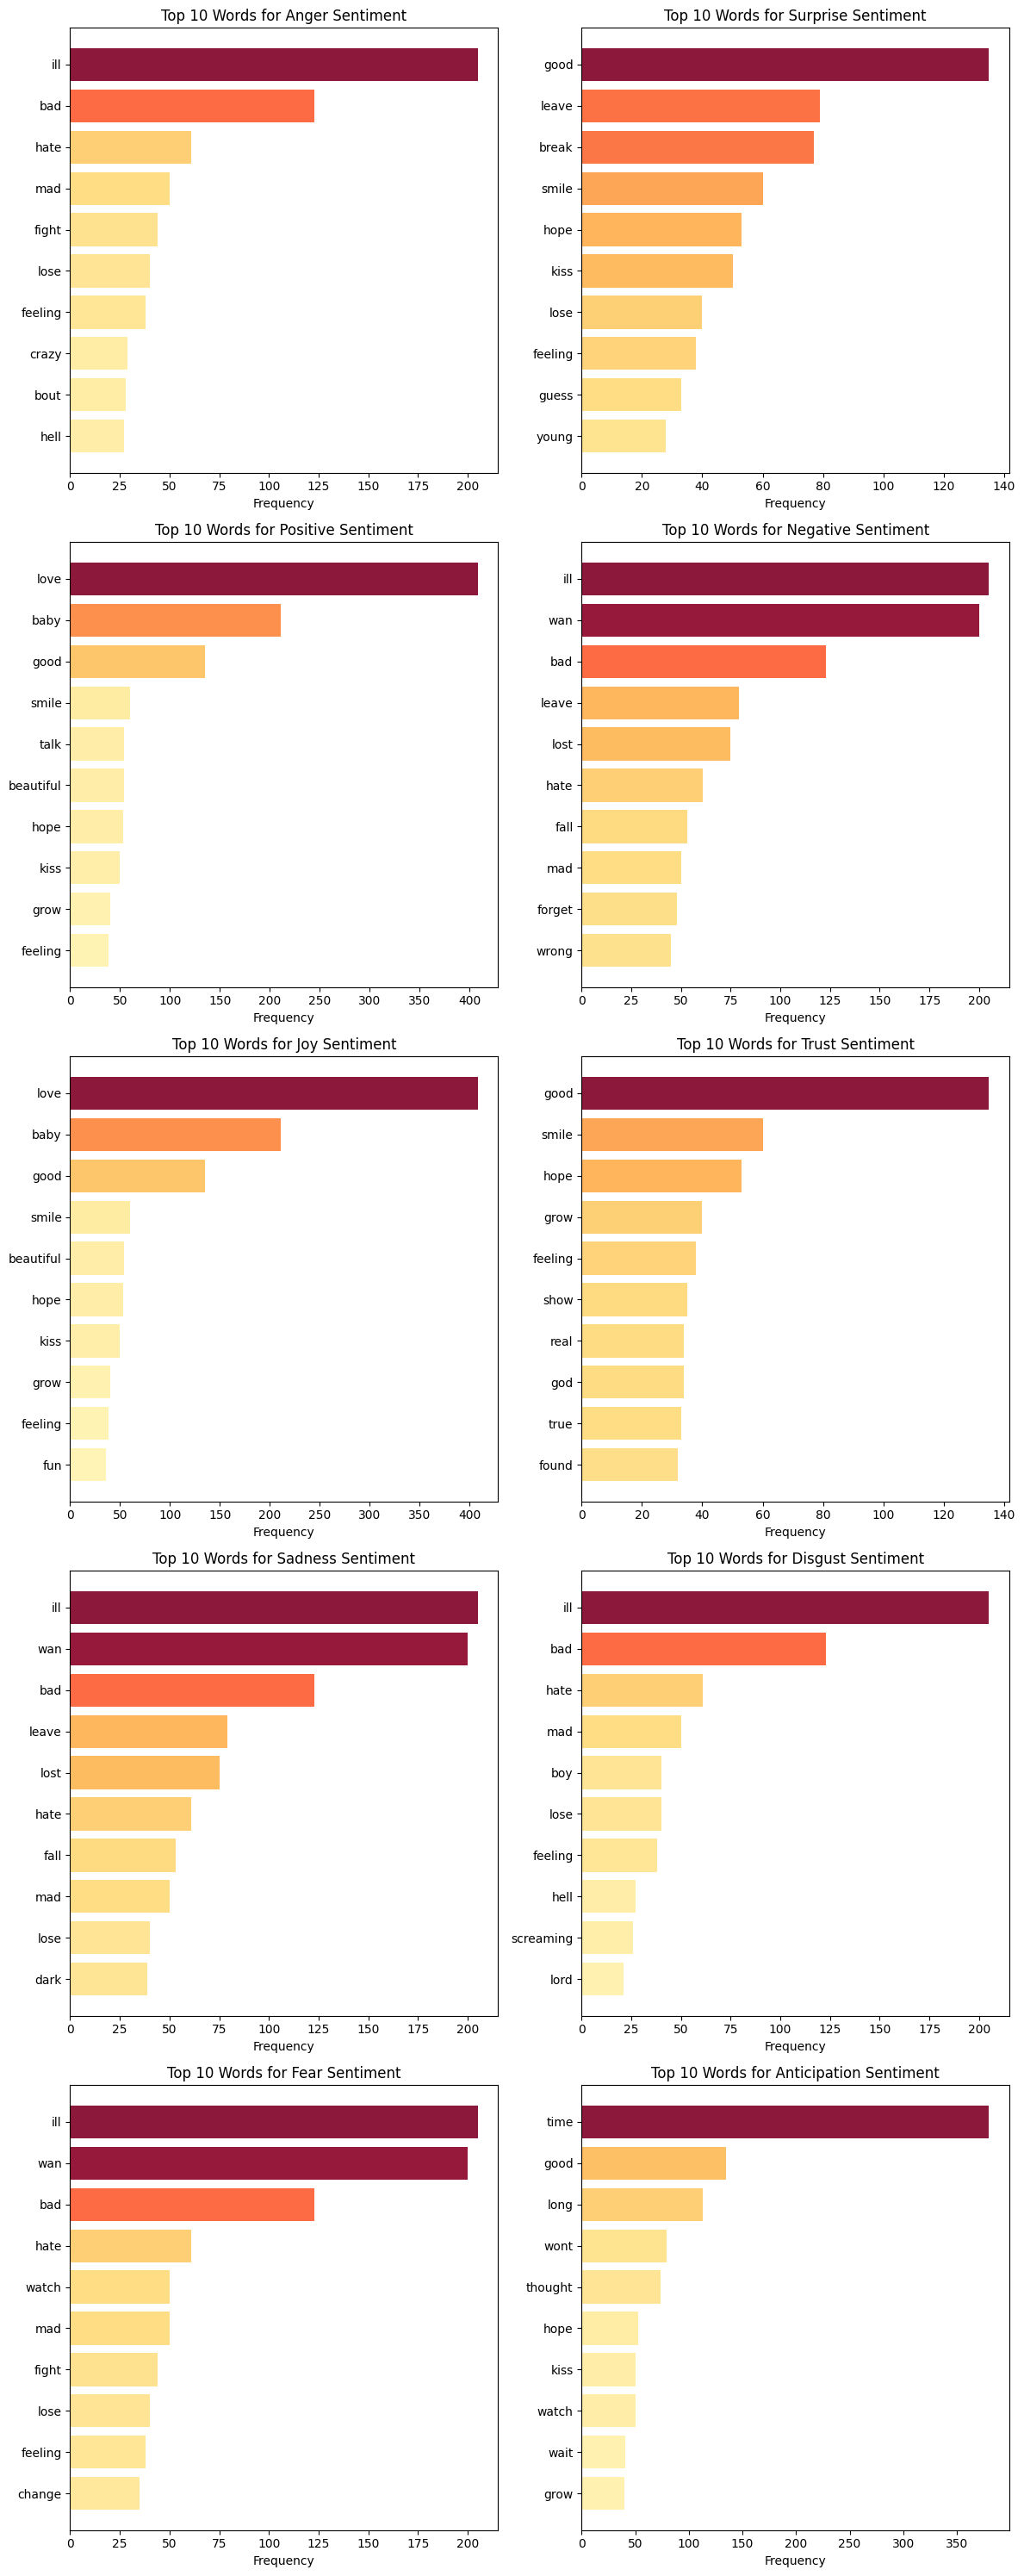

In [78]:
# create pandas Series from the list of filtered tokens
word_series = pd.Series(filtered_tokens)

# create dictionary to store word frequencies for each sentiment
sentiment_word_counts = {}

# calculate word frequencies for each sentiment
for sentiment in unique_sentiments:
    words_for_sentiment = [word for word, emotions in text_object.affect_dict.items() if sentiment in emotions]
    sentiment_word_counts[sentiment] = word_series[word_series.isin(words_for_sentiment)].value_counts().head(10)

# plot bar graph for each sentiment
num_rows = len(unique_sentiments) // 2 + (1 if len(unique_sentiments) % 2 != 0 else 0)
num_cols = 2
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 6))
axs = axs.ravel()

for i, sentiment in enumerate(unique_sentiments):
    word_counts = sentiment_word_counts[sentiment]
    axs[i].barh(word_counts.index, word_counts.values, color=plt.cm.YlOrRd(word_counts.values / max(word_counts.values)), alpha=0.9)
    axs[i].set_title(f'Top 10 Words for {sentiment.capitalize()} Sentiment')
    axs[i].set_xlabel('Frequency')
    axs[i].tick_params(axis='y')
    axs[i].set_yticklabels(word_counts.index)
    axs[i].invert_yaxis()

# hide remaining empty subplots
for j in range(len(unique_sentiments), num_rows * num_cols):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

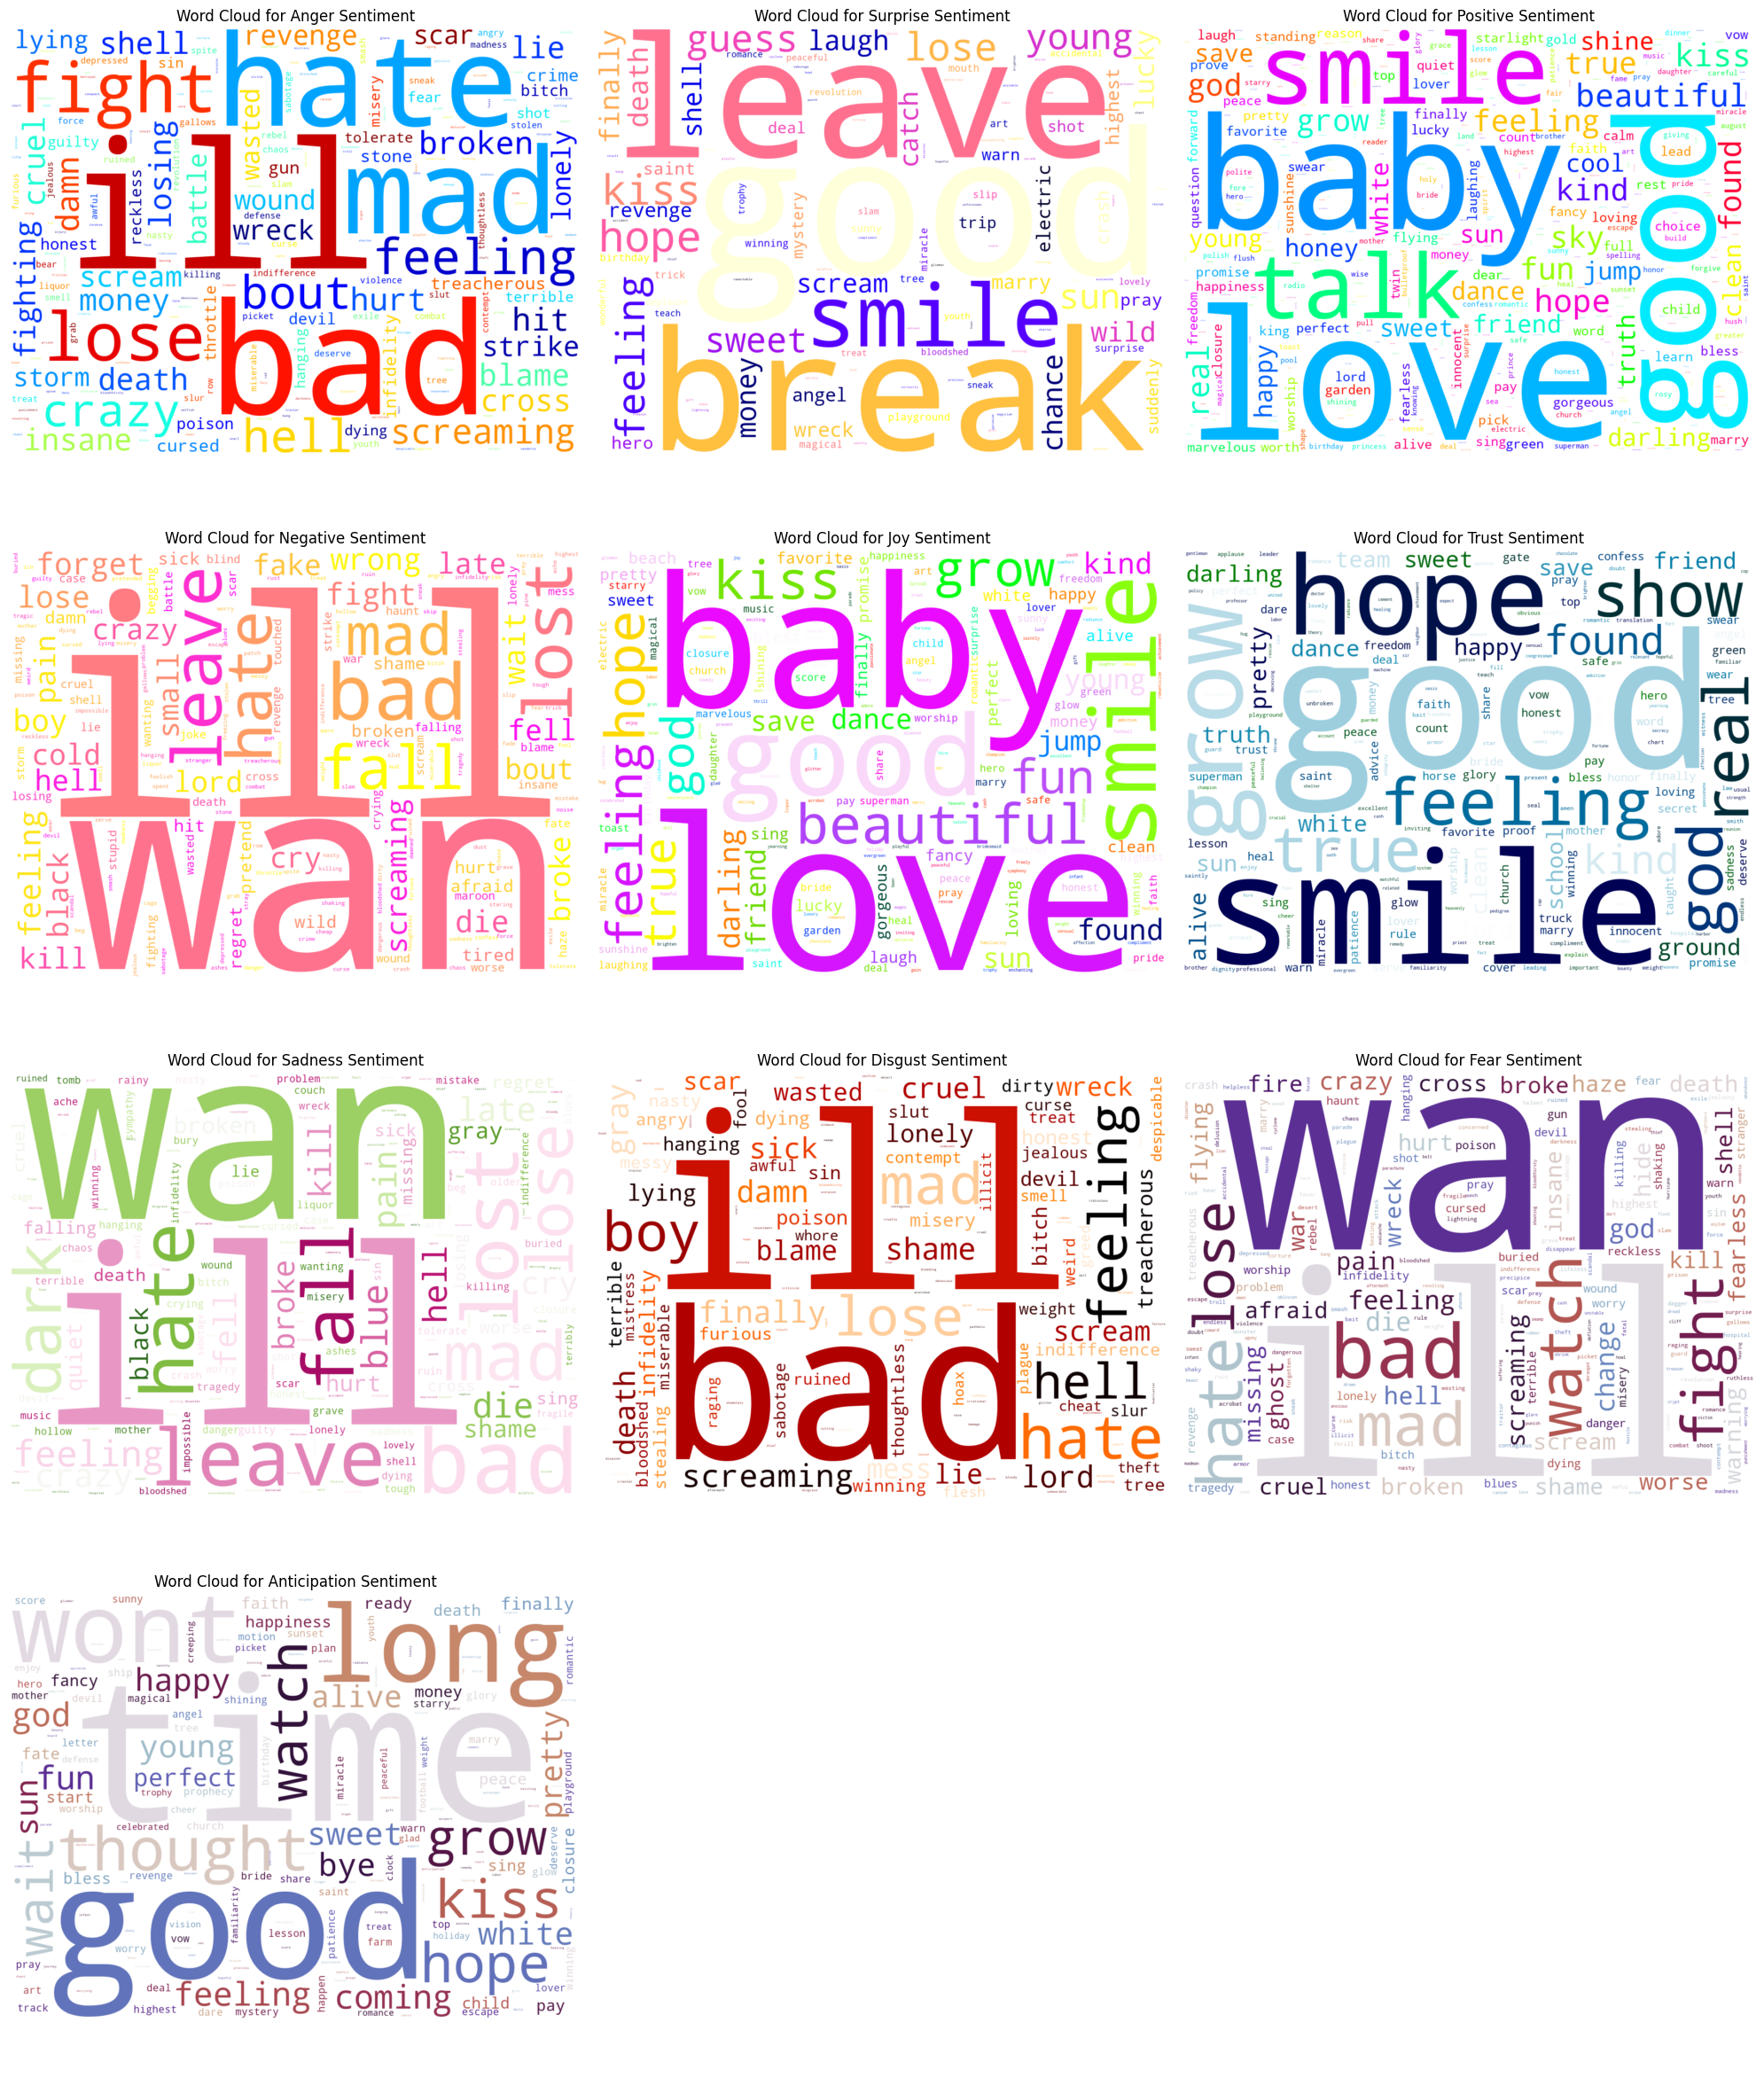

In [79]:
# determine no. of rows and columns needed
num_rows = len(unique_sentiments) // 3 + (1 if len(unique_sentiments) % 3 != 0 else 0)
num_cols = 3

# create subplots with 3 columns
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 6))

# flatten the axis array
axs = np.ravel(axs)

# calculate word frequencies for each sentiment
for sentiment in unique_sentiments:
    words_for_sentiment = [word for word, emotions in text_object.affect_dict.items() if sentiment in emotions]
    sentiment_word_counts[sentiment] = word_series[word_series.isin(words_for_sentiment)].value_counts()

    
# create wordcloud for each sentiment
for i, sentiment in enumerate(unique_sentiments):
    words_for_sentiment = [word for word, emotions in text_object.affect_dict.items() if sentiment in emotions]
    word_counts = sentiment_word_counts[sentiment]

    # create wordcloud
    wordcloud = WordCloud(
        relative_scaling=0.3,
        min_font_size=1,
        background_color="white",
        width=400,
        height=300,
        max_words=500,
        colormap=sentiment_cmaps.get(sentiment),
        scale=3,
        font_step=4,
        collocations=False,
        margin=5
        )

    # generate wordcloud
    wordcloud.generate_from_frequencies(word_counts.to_dict())

    # display wordcloud in the respective subplot
    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].set_title(f"Word Cloud for {sentiment.capitalize()} Sentiment")
    axs[i].axis('off')

# hide remaining empty subplots
for j in range(len(unique_sentiments), num_rows * num_cols):
    axs[j].axis('off')

# adjust layout
plt.tight_layout()
plt.show()
